## **Implementation of the Vision Transformer**

### **Importing necessary libraries**

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **DataPreprocessing : Loading the data in batches using dataloader and applying the transformation of converting the input images to PyTorch tensors and printing the dataset information**

In [12]:
# device = torch.device('cuda:0')
# Define the transformation that converts the image to tensor and normalizes it
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor()])

# Define the path to the parent directory which contains the training and test folders
data_dir = "/content/drive/MyDrive/Satellite binary data"


# Load the training dataset
train_dataset = datasets.ImageFolder(root=data_dir+'/train_another',transform = transform)

# Load the test dataset
test_dataset = datasets.ImageFolder(root=data_dir+'/test_another',transform = transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print some information about the datasets
print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Classes: {train_dataset.classes}')

Training dataset size: 10000
Test dataset size: 9000
Classes: ['damage', 'no_damage']


### **Checking the first batch of images and labels from the trainloader**

Images shape: torch.Size([64, 3, 64, 64])
Labels shape: torch.Size([64])


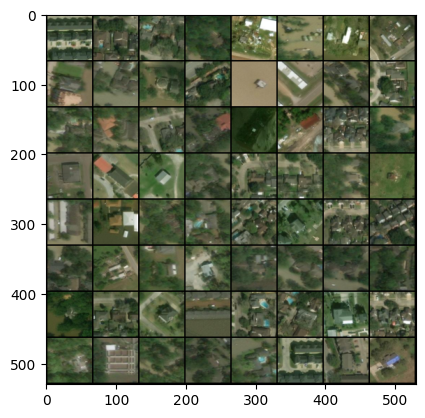

In [4]:
for images, labels in trainloader:
    break

# Display a grid of images
grid = vutils.make_grid(images, nrow=8, padding=2, normalize=True)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

# Print the shapes of the images and labels
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


### **Function to divide the input images into patches**

In [5]:
def split_image_into_patches(images, patch_size):
    batch_size, num_channels, height, width = images.shape
    num_vert_patches = height // patch_size
    num_horiz_patches = width // patch_size
    
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.reshape(batch_size, num_channels, num_vert_patches*num_horiz_patches, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4)
    patches = patches.reshape(batch_size, num_vert_patches*num_horiz_patches, num_channels*patch_size*patch_size)
    
    return patches

### **Displaying an image that is divided into patches along with the original image**

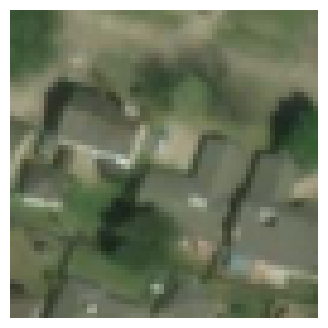

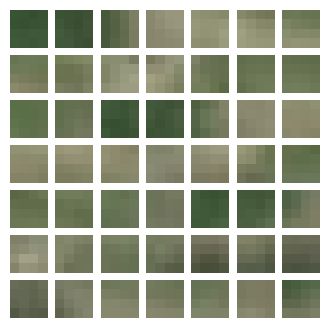

In [6]:
# Get one batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Get one image from the batch
image = images[0]

# Split the image into patches
patches = split_image_into_patches(image.unsqueeze(0), 4)

# Calculate the number of patches in each dimension to create a 7x7 grid of 4x4 patches
num_patches = patches.shape[1]
num_cols = 7
num_rows = 7

# Display the original image
plt.figure(figsize=(4,4))
plt.imshow(np.moveaxis(image.numpy(), 0, -1))
plt.axis('off')
plt.show()


# Display the patches in a 7x7 grid of 4x4 patches
plt.figure(figsize=(4,4))
for i in range(num_rows):
    for j in range(num_cols):
        plt.subplot(num_rows, num_cols, i*num_cols+j+1)
        plt.imshow(np.transpose(patches[0, i*num_cols+j].reshape(3,4,4), (1,2,0)))
        plt.axis('off')
plt.show()

### **Function that takes the flattened patches and projects it to the embedding dimension**

In [7]:
def embed_patches(patches, embedding_dim):
  
    # Define the linear embedding layer
    embed_layer = nn.Linear(in_features=patches.shape[-1], out_features=embedding_dim)

    # Apply the embedding layer to the flattened tensor
    embed_patches = embed_layer(patches)  # shape: [num_images * num_patches, embedding_dim]

    return embed_patches

### **Function to add the positional encoding to the embedding patches**

In [8]:
def get_position_encoding(embeddings):
    num_images, num_patches, embedding_dim = embeddings.shape
    seq_length = num_patches * num_images
    num_patches = num_patches
    num_images = num_images

    pos_encoding = torch.zeros(seq_length, embedding_dim)
    position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embedding_dim, 2, dtype=torch.float) * (-math.log(10000.0) / embedding_dim))
    pos_encoding[:, 0::2] = torch.sin(position * div_term)
    pos_encoding[:, 1::2] = torch.cos(position * div_term)
    pos_encoding = pos_encoding[:num_patches, :].unsqueeze(0).repeat(num_images, 1, 1)
    pos_encoding = pos_encoding.reshape(-1, pos_encoding.size(-1))
    pos_encoding = pos_encoding.view(num_images, num_patches, embedding_dim)

    return pos_encoding

### **Encoder block function with Multi-head attention and the fully connected network**

In [19]:
# Define the Encoder block with multi-head attention
class EncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4*embed_dim),
            nn.GELU(),
            nn.Linear(4*embed_dim, embed_dim)
        )

    def forward(self, x):
        # Layer normalization
        x_norm = self.norm1(x)

        # Multi-head attention with residual connection
        attn_output, _ = self.mha(x_norm, x_norm, x_norm)
        x = x + attn_output

        # Layer normalization
        x_norm = self.norm2(x)

        # Feed-forward network with residual connection
        ffn_output = self.ffn(x_norm)
        x = x + ffn_output

        return x


### **MLP Classifer Head**

In [20]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        # out = self.relu(out)
        # out = self.fc3(out)
        return out

### **Implementation of the ViT Model**

In [21]:
class ViT(nn.Module):

    def __init__(self, inputs, patch_size, embed_dim, input_size, num_heads, hidden_dim, num_classes, device):
        super(ViT, self).__init__()

        self.inputs = inputs
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.device = device

        self.class_token = nn.Parameter(torch.rand(1, self.embed_dim))

        # self.encoder_block = EncoderBlock(self.hidden_dim, self.num_heads)
        encoder_blocks = []
        for i in range(2):
            encoder_blocks.append(EncoderBlock(self.embed_dim, self.num_heads))
        self.encoder_block = nn.Sequential(*encoder_blocks)

        self.mlp_head = MLPClassifier(self.input_size, self.hidden_dim, self.num_classes)
       
    def forward(self, inputs):

        patches = split_image_into_patches(inputs, self.patch_size)

        embed_layer = embed_patches(patches, self.embed_dim)
        tokens = torch.stack([torch.vstack((self.class_token, embed_layer[i])) for i in range(len(embed_layer))])
        
        pos_encoding = get_position_encoding(tokens)
        
        embeddings = tokens + pos_encoding


        # Apply Encoder block to input in batches
        encoded_sequence = self.encoder_block(embeddings)



        encoded_output = encoded_sequence.flatten(1)


        # Pass through MLP
        mlp_output = self.mlp_head(encoded_output)

        return mlp_output


In [40]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize ViT model
vit_model = ViT(inputs = (3,64,64), patch_size = 4, embed_dim = 128, input_size = 32896, num_heads = 4, hidden_dim = 256, num_classes = 10, device = device)

# move model to device
vit_model

ViT(
  (encoder_block): Sequential(
    (0): EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
    )
    (1): EncoderBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_fea

In [41]:
path = '/content/model_binary_10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

checkpoint = torch.load(path)
vit_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
curr_epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [35]:
with torch.no_grad():
    correct, total = 0, 0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    test_loss = 0.0
    for batch in tqdm(testloader, desc="Testing"):
        x, y = batch
        # x, y = x.to(device), y.to(device)
        y_hat = vit_model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(testloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████| 71/71 [54:03<00:00, 45.68s/it]

Test loss: 0.65
Test accuracy: 84.24%


In [42]:
checkpoint = torch.load(path)
vit_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
curr_epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [44]:
for epoch in range(curr_epoch+1, 15):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(trainloader):
        
        # data, target = data.to(device), target.to(device)

        # Forward pass
        outputs = vit_model(data)
        loss = criterion(outputs, target)

        # Backward pass and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics
        if batch_idx % 100 == 0: # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}: Loss {running_loss / 100:.3f}')
            running_loss = 0.0

with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(testloader, desc="Testing"):
        x, y = batch
        # x, y = x.to(device), y.to(device)
        y_hat = vit_model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(testloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Epoch 11, Batch 1: Loss 0.007
Epoch 12, Batch 1: Loss 0.007
Epoch 13, Batch 1: Loss 0.007
Epoch 14, Batch 1: Loss 0.007
Epoch 15, Batch 1: Loss 0.007


Testing: 100%|██████████| 71/71 [01:30<00:00,  1.28s/it]

Test loss: 0.57
Test accuracy: 85.98%


In [45]:
path = './model_binary_15.pt'

torch.save({
        'epoch': epoch,
        'model_state_dict': vit_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }, path)

In [46]:
checkpoint = torch.load(path)
vit_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
curr_epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [47]:
for epoch in range(curr_epoch+1, 20):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(trainloader):
        
        # data, target = data.to(device), target.to(device)

        # Forward pass
        outputs = vit_model(data)
        loss = criterion(outputs, target)

        # Backward pass and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print statistics
        if batch_idx % 100 == 0: # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}: Loss {running_loss / 100:.3f}')
            running_loss = 0.0

with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(testloader, desc="Testing"):
        x, y = batch
        # x, y = x.to(device), y.to(device)
        y_hat = vit_model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(testloader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Epoch 16, Batch 1: Loss 0.007
Epoch 17, Batch 1: Loss 0.007
Epoch 18, Batch 1: Loss 0.007
Epoch 19, Batch 1: Loss 0.007
Epoch 20, Batch 1: Loss 0.007


Testing: 100%|██████████| 71/71 [01:35<00:00,  1.35s/it]

Test loss: 0.57
Test accuracy: 85.87%


In [48]:
path = './model_binary_20.pt'

torch.save({
        'epoch': epoch,
        'model_state_dict': vit_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss
    }, path)

### **Model Evaluation**

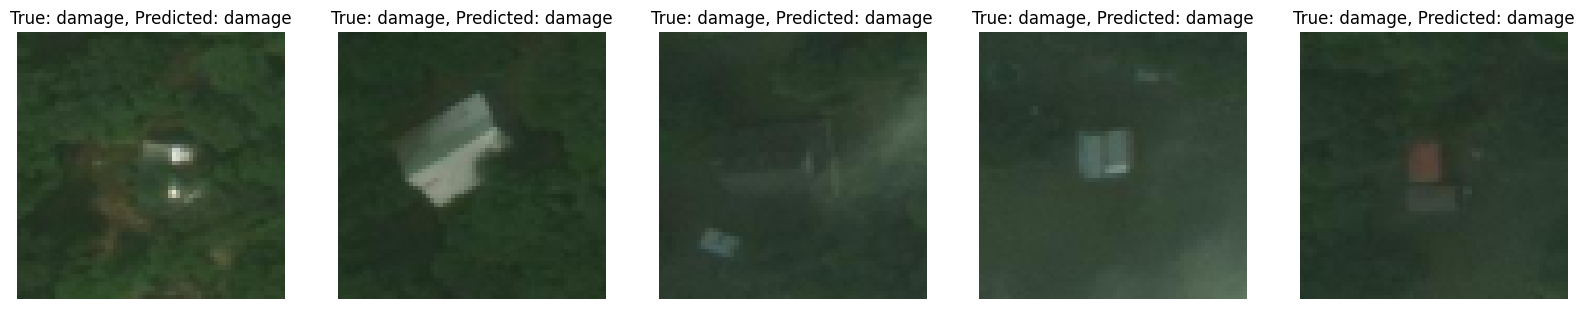

In [49]:
# set the model to evaluation mode
vit_model.eval()

class_names = train_dataset.classes

# get a few random test images
test_dataiter = iter(testloader)
images, labels = next(test_dataiter)

# make predictions on the test images
with torch.no_grad():
    outputs = vit_model(images.to(device))
    _, predicted = torch.max(outputs.data, 1)
    predicted = predicted.cpu().numpy()

# map the labels to their corresponding class names
true_labels = [class_names[label] for label in labels]
predicted_labels = [class_names[label] for label in predicted]

# plot the test images with their predicted labels
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    ax.axis("off")
plt.show()